In [1]:
from pathlib import Path
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
import os
import random

gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0:
  tf.config.experimental.set_memory_growth(gpus[0], True)
  print('Memory growth enabled on gpu', gpus[0])

from IPython.display import clear_output
import matplotlib as mpl
import matplotlib.pyplot as plt

tf.__version__

Memory growth enabled on gpu PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


'2.1.0'

In [2]:
import pspnetmodel
import json

# dataset_dir = Path() / 'drive' / 'Shared drives' / 'IPCV' / 'dataset'
dataset_dir = Path() / 'dataset'

train_dir = dataset_dir / "train"
test_dir = dataset_dir / "test"
val_dir = dataset_dir / "val"

checkpoint_path = dataset_dir / "checkpoints"
log_path = dataset_dir / "logs"

tr = list((train_dir / 'rgb').iterdir())
tt = list((test_dir / 'rgb').iterdir())
v = list((val_dir / "rgb").iterdir())

labels = json.load(open('labels.json'))

train_len = len(tr)
test_len = len(tt)
val_len = len(v)

list(zip(
    ('train len', 'test_len', 'val_len'),
    (train_len, test_len, val_len)
))

[('train len', 7234), ('test_len', 2068), ('val_len', 1033)]

In [29]:
#GENERATORS 
SIZE = 300
BATCH_SIZE = 16
STEPS_TRAIN = np.ceil(train_len / BATCH_SIZE)
STEPS_VAL = np.ceil(val_len / BATCH_SIZE)

def data_gen(folder, batch_size=BATCH_SIZE, seed=0):
  c = 0
  
  img_folder = str(folder / 'rgb')
  mask_folder = str(folder / 'seg')

  n = os.listdir(img_folder) #List of training images
  random.seed(seed)
  random.shuffle(n)

  while True:
    img = np.zeros((batch_size, SIZE, SIZE, 3)).astype('float')
    mask = np.zeros((batch_size, SIZE, SIZE, 1)).astype('float')

    for i in range(c, c+batch_size): 
      train_img = tf.io.read_file(img_folder+'/'+n[i])
      train_img = tf.image.decode_jpeg(train_img, channels=3)
      train_img = tf.image.convert_image_dtype(train_img, tf.float32) / 255
      #train_img = tf.cast(train_img, tf.float32) / 255.0
      train_img = tf.image.resize(train_img, (SIZE, SIZE))
      
      img[i-c] = train_img #add to array - img[0], img[1], and so on.

      mask_path = (mask_folder+'/'+n[i]).split(".")[0] + ".png"

      train_mask = tf.io.read_file(mask_path)
      train_mask = tf.image.decode_png(train_mask, channels=1)
      train_mask = tf.image.resize(train_mask, (SIZE, SIZE))
      mask[i-c] = train_mask

    c+=batch_size
    if c+batch_size >= len(n):
      c=0
      random.shuffle(n)
                  
    yield img, mask

train_gen, val_gen, test_gen = [None] * 3

def refresh_generators(batch_size=BATCH_SIZE, seed=0):
  global train_gen, val_gen, test_gen

  train_gen = data_gen(train_dir, batch_size, seed)
  val_gen = data_gen(val_dir, batch_size, seed)
  test_gen = data_gen(test_dir, batch_size, seed)

refresh_generators()

assert all(gen is not None for gen in (train_gen, val_gen, test_gen))
'Refresh generators done'

'Refresh generators done'

In [30]:
def display(display_list, height=8):
  l = len(display_list)
  assert l < 4, 'Fornire in ingresso al più 3 immagini'

  fig, ax = plt.subplots(1, l, figsize=(height*l, height))
  afig, aax = plt.subplots(1, 1, figsize=(20, 1))
  titles = ['Input Image', 'True Mask', 'Predicted Mask']

  # https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
  # https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.colors.ListedColormap.html
  # ListedColormap per enumerare i colori desiderati
  cmap = mpl.cm.gnuplot
  bounds = np.linspace(0, len(labels), len(labels)+1)
  norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

  labels_dict = dict(zip(range(len(labels)), labels))
  def get_labels(values):
    return [label for key, label in labels_dict.items() if key in values]

  for i in range(l):
    x = display_list[i]
    # il primo controllo non ci fa crashare se abbiamo un'imm a 0 canali (1 implicito)
    # il secondo serve a capire quanti canali ci sono nella terza dim
    rgb = len(x.shape) > 2 and x.shape[2] > 1

    if rgb:
      x = tf.keras.preprocessing.image.array_to_img(x)
    else:
      x = x.squeeze()

    title = titles[i]
    ax[i].set_title(title)
    ax[i].imshow(x, cmap=cmap, vmin=0, vmax=len(labels) - 1)
    ax[i].axis('off')
    if not rgb:
      uniques = [e for e in np.unique(x) if np.round(e) == e]
      print('IMAGE: ', title)
      print('LABELS:', get_labels(uniques))
      print()

  cb = mpl.colorbar.ColorbarBase(
    aax, cmap=cmap,
    norm=norm,
    boundaries=bounds,
    ticks=bounds,
    spacing='proportional',
    orientation='horizontal'
  )
  cb.ax.set_xticklabels(labels, rotation=70, size='large', ha='left')

  plt.show()

'Display function set'

'Display function set'

IMAGE:  True Mask
LABELS: ['UNLABELED', 'wall', 'floor', 'cabinet', 'sofa', 'table', 'door', 'window', 'bookshelf', 'picture', 'curtain', 'books', 'lamp', 'bag']



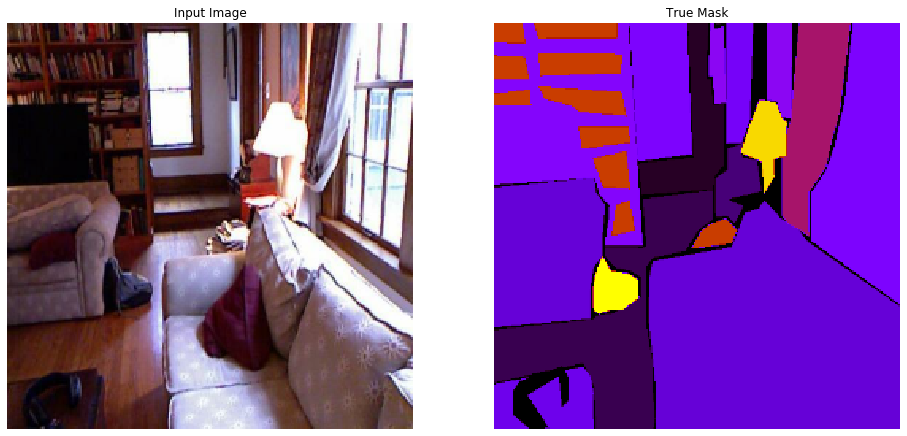

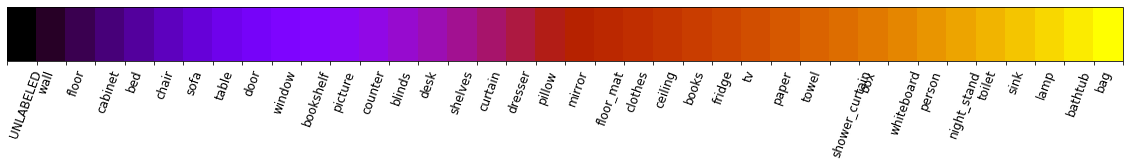

In [26]:
refresh_generators()
image_batch, mask_batch = next(train_gen)
sample_image, sample_mask = image_batch[0], mask_batch[0]
display([sample_image, sample_mask])

In [6]:
def Mean_IOU_tensorflow_2(y_true, y_pred):
    nb_classes = K.int_shape(y_pred)[-1]
    iou = []
    true_pixels = K.argmax(y_true, axis=-1)
    pred_pixels = K.argmax(y_pred, axis=-1)
    void_labels = K.equal(K.sum(y_true, axis=-1), 0)
    for i in range(0, nb_classes): # exclude first label (background) and last label (void)
        true_labels = K.equal(true_pixels, i) & ~void_labels
        pred_labels = K.equal(pred_pixels, i) & ~void_labels
        inter = tf.cast(true_labels & pred_labels, tf.int32)#tf.to_int32(true_labels & pred_labels)
        union = tf.cast(true_labels | pred_labels, tf.int32)#tf.to_int32(true_labels | pred_labels)
        legal_batches = K.sum(tf.cast(true_labels, tf.int32), axis=1)>0
        ious = K.sum(inter, axis=1)/K.sum(union, axis=1)
        iou.append(K.mean(ious[legal_batches]))
    iou = tf.stack(iou)
    legal_labels = ~tf.math.is_nan(iou)
    iou = iou[legal_labels]
    return K.mean(iou)

def jaccard_distance(y_true, y_pred, smooth=100):
    """Jaccard distance for semantic segmentation.
    Also known as the intersection-over-union loss.
    This loss is useful when you have unbalanced numbers of pixels within an image
    because it gives all classes equal weight. However, it is not the defacto
    standard for image segmentation.
    For example, assume you are trying to predict if
    each pixel is cat, dog, or background.
    You have 80% background pixels, 10% dog, and 10% cat.
    If the model predicts 100% background
    should it be be 80% right (as with categorical cross entropy)
    or 30% (with this loss)?
    The loss has been modified to have a smooth gradient as it converges on zero.
    This has been shifted so it converges on 0 and is smoothed to avoid exploding
    or disappearing gradient.
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

def jaccard_crossentropy(out, tar):
        return tf.keras.losses.categorical_crossentropy(out, tar) + jaccard_distance(out, tar)

In [31]:
#model = unet_model(SIZE, OUTPUT_CHANNELS, down_stack, up_stack)
OUTPUT_CHANNELS = 38

model = pspnetmodel.PSPNet50(
  input_shape=(SIZE, SIZE, 3),
  n_labels=OUTPUT_CHANNELS
)

opt = tf.keras.optimizers.Adam(
  learning_rate=1e-3,
  amsgrad=True,
)

#metrics
miou = tf.keras.metrics.MeanIoU(OUTPUT_CHANNELS)
scc = tf.keras.metrics.SparseCategoricalAccuracy()
acc = "accuracy"
spacc = 'sparse_categorical_accuracy'

#losses
hinge_loss = tf.keras.losses.Hinge()
sparse_softmax = tf.nn.sparse_softmax_cross_entropy_with_logits
cross_entropy = tf.keras.losses.categorical_crossentropy
sparse_cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy()
mse = tf.keras.losses.MeanSquaredError()
tf_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# run options
run_opts = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom=True)

model.compile(
  optimizer=opt,
  loss=sparse_cross_entropy,
  metrics=[spacc]
)
#model.summary()

ValueError: Negative dimension size caused by subtracting 30 from 19 for 'pool_level_6_16_6/AvgPool' (op: 'AvgPool') with input shapes: [?,19,19,2048].

IMAGE:  True Mask
LABELS: ['UNLABELED', 'wall', 'floor', 'cabinet', 'sofa', 'table', 'door', 'window', 'bookshelf', 'picture', 'curtain', 'books', 'lamp', 'bag']

IMAGE:  Predicted Mask
LABELS: ['UNLABELED', 'wall', 'floor', 'cabinet', 'bed', 'chair', 'sofa', 'table', 'door', 'window', 'bookshelf', 'picture', 'counter', 'blinds', 'desk', 'shelves', 'curtain', 'dresser', 'pillow', 'mirror', 'floor_mat', 'clothes', 'ceiling', 'books', 'fridge', 'tv', 'paper', 'towel', 'shower_curtain', 'box', 'whiteboard', 'person', 'night_stand', 'toilet', 'sink', 'lamp', 'bathtub', 'bag']



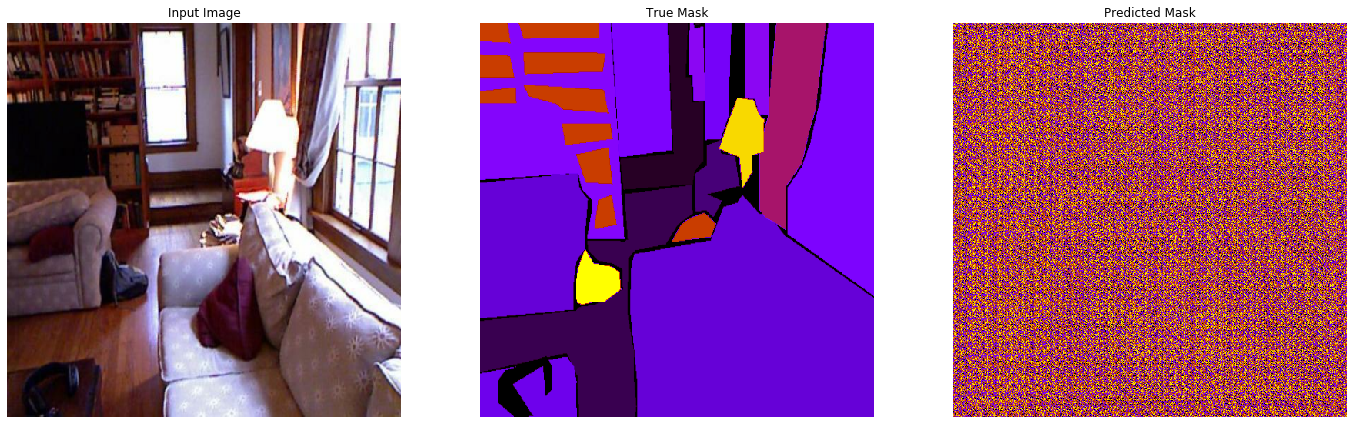

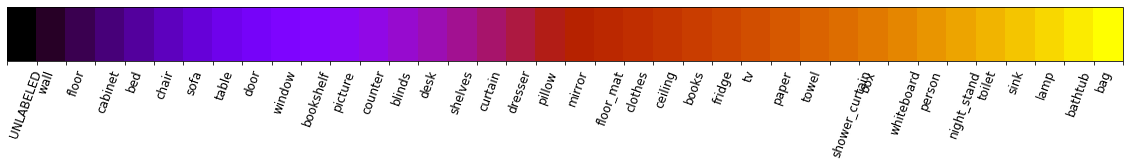

In [18]:
def create_mask(mask):
    """Quick utility to display a model's prediction."""
    mask = mask.squeeze()
    size = np.int(mask.shape[0] ** (1/2))
    classes = mask.shape[1]
    mask = mask.reshape(size, size, classes)
    mask = np.argmax(mask, axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    return mask


def show_predictions(datagen=None):
  image, mask = None, None

  if not datagen:
    image, mask = sample_image, sample_mask
  else:
    for img_batch, m_batch in datagen:
      image, mask = [batch[0] for batch in (img_batch, m_batch)]
      break

  prediction = create_mask(model.predict(image[tf.newaxis, ...]))
  display([image, mask, prediction])

show_predictions()

IMAGE:  True Mask
LABELS: ['UNLABELED', 'wall', 'floor', 'cabinet', 'sofa', 'table', 'door', 'window', 'bookshelf', 'picture', 'curtain', 'books', 'lamp', 'bag']

IMAGE:  Predicted Mask
LABELS: ['UNLABELED', 'wall', 'floor', 'cabinet', 'bed', 'chair', 'sofa', 'table', 'door', 'window', 'bookshelf', 'picture', 'counter', 'blinds', 'desk', 'shelves', 'curtain', 'dresser', 'pillow', 'mirror', 'floor_mat', 'clothes', 'ceiling', 'books', 'fridge', 'tv', 'paper', 'towel', 'shower_curtain', 'box', 'whiteboard', 'person', 'night_stand', 'toilet', 'sink', 'lamp', 'bathtub', 'bag']


Sample Prediction after epoch 1

  1/453 [..............................] - ETA: 2:35:30

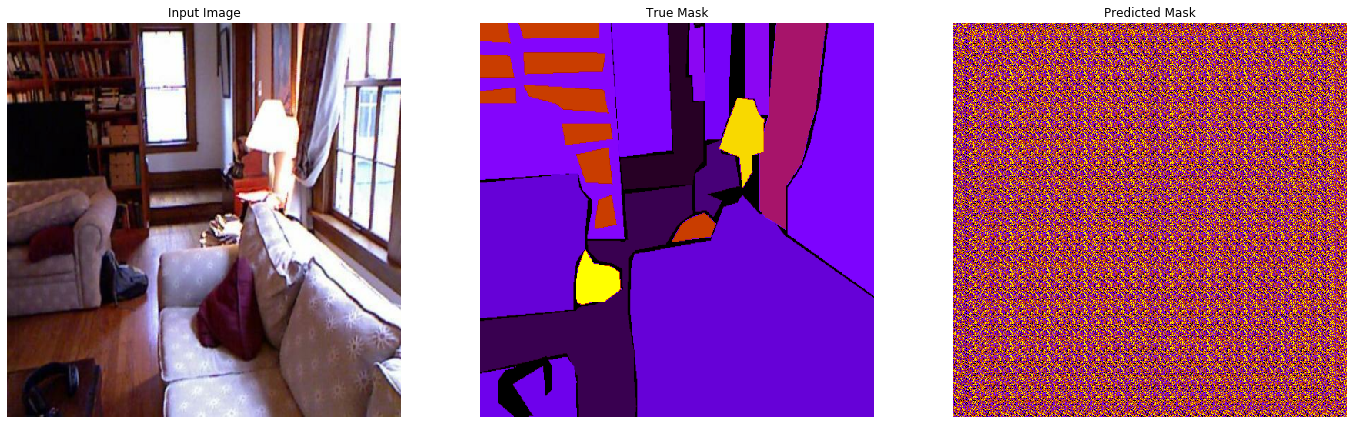

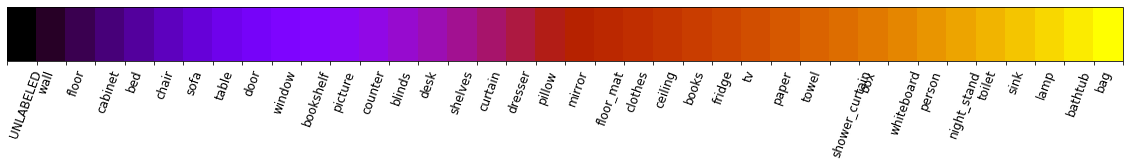

ResourceExhaustedError:  OOM when allocating tensor with shape[16,256,127,127] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_3/bn2b_branch2c/FusedBatchNormV3 (defined at <ipython-input-19-5a2710f95e76>:33) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_56449]

Function call stack:
distributed_function


In [19]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))


EPOCHS = 15

cp_name = 'pspnet50_sparsecategorical'
cp_path = str(checkpoint_path / cp_name)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    cp_path + '.h5',
    save_weights_only=True,
    save_best_only=True,
    verbose=1
)
 
cbck = [
    DisplayCallback(),
    cp_callback,
]

refresh_generators()

model_history = model.fit(
  train_gen,
  epochs=EPOCHS,
  steps_per_epoch=STEPS_TRAIN,
  validation_steps=STEPS_VAL,
  validation_data=val_gen,
  callbacks=cbck,
)


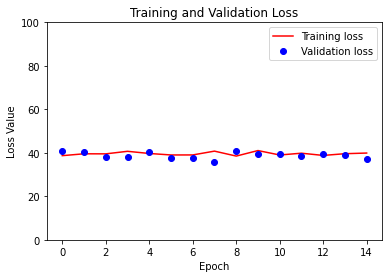

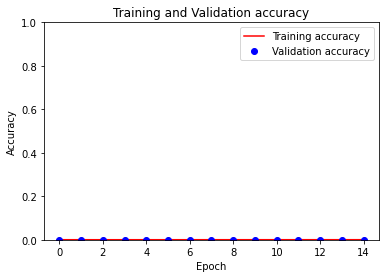

In [0]:
loss = model_history.history['loss']
acc = model_history.history['accuracy']
val_loss = model_history.history['val_loss']
val_acc = model_history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure()
#LOSS
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 100])
plt.legend()

#ACCURACY
plt.figure()
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'bo', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()

plt.show()

UNET MODEL
